In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from shap import KernelExplainer, DeepExplainer
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import time

pd.set_option('display.max_columns', None)

keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

2023-12-01 09:50:39.967467: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 09:50:39.970041: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 09:50:40.003513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 09:50:40.003552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 09:50:40.004695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
tf.config.threading.set_intra_op_parallelism_threads(10)
tf.config.threading.set_inter_op_parallelism_threads(6)

In [3]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest, average='binary'):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain, average = average),
                metricsObj.recall_score(yTrain, yPredTrain, average = average),
                metricsObj.f1_score(yTrain, yPredTrain, average = average),
                metricsObj.roc_auc_score(yTrain, yPredTrain, average = None if average == 'binary' else average)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest, average = average),
               metricsObj.recall_score(yTest, yPredTest, average = average),
               metricsObj.f1_score(yTest, yPredTest, average = average),
               metricsObj.roc_auc_score(yTest, yPredTest, average = None if average == 'binary' else average)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [4]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

- aggiungere cross validation
- passare a usare i sample
- guardare la dimesione dell'albero
- confrontare sample con dati interi

Here I change the type of some feature becuase since they come from a network package they are supposed to be a certain amount of bit maximum, I also checked before to do the change.

Then I will eclude the ip of the hosts, the port and the Unnamed: 0. Because the ip and ports are categorical but they are to many to fit in the model, and also there is not a good reason for train the model over the ip since it change based on the network so the attacker will always have a different one. About the Unnamed: 0 you can use that number to split this csv in mani csvs which is not a thing that we need to do so I removed that feature as well.

In [5]:
dtype_dict = {
    'Unnamed: 0': 'uint32',
    'uid': 'str',
    'originh': 'category',
    'originp': 'uint16',
    'responh': 'category',
    'responp': 'uint16',
    'flow_duration': 'float64',
    'fwd_pkts_tot': 'uint64',
    'bwd_pkts_tot': 'uint64',
    'fwd_data_pkts_tot': 'uint64',
    'bwd_data_pkts_tot': 'uint64',
    'fwd_pkts_per_sec': 'float64',
    'bwd_pkts_per_sec': 'float64',
    'flow_pkts_per_sec': 'float64',
    'down_up_ratio': 'float32',
    'fwd_header_size_tot': 'uint64',
    'fwd_header_size_min': 'uint8',
    'fwd_header_size_max': 'uint8',
    'bwd_header_size_tot': 'uint64',
    'bwd_header_size_min': 'uint8',
    'bwd_header_size_max': 'uint8',
    'flow_FIN_flag_count': 'uint64',
    'flow_SYN_flag_count': 'uint64',
    'flow_RST_flag_count': 'uint64',
    'fwd_PSH_flag_count': 'uint64',
    'bwd_PSH_flag_count': 'uint64',
    'flow_ACK_flag_count': 'uint64',
    'fwd_URG_flag_count': 'uint64',
    'bwd_URG_flag_count': 'uint64',
    'flow_CWR_flag_count': 'uint64',
    'flow_ECE_flag_count': 'uint64',
    'fwd_pkts_payload.min': 'uint16',
    'fwd_pkts_payload.max': 'uint16',
    'fwd_pkts_payload.tot': 'float64',
    'fwd_pkts_payload.avg': 'float64',
    'fwd_pkts_payload.std': 'float64',
    'bwd_pkts_payload.min': 'uint16',
    'bwd_pkts_payload.max': 'uint16',
    'bwd_pkts_payload.tot': 'float64',
    'bwd_pkts_payload.avg': 'float64',
    'bwd_pkts_payload.std': 'float64',
    'flow_pkts_payload.min': 'uint16',
    'flow_pkts_payload.max': 'uint16',
    'flow_pkts_payload.tot': 'float64',
    'flow_pkts_payload.avg': 'float64',
    'flow_pkts_payload.std': 'float64',
    'fwd_iat.min': 'float64',
    'fwd_iat.max': 'float64',
    'fwd_iat.tot': 'float64',
    'fwd_iat.avg': 'float64',
    'fwd_iat.std': 'float64',
    'bwd_iat.min': 'float64',
    'bwd_iat.max': 'float64',
    'bwd_iat.tot': 'float64',
    'bwd_iat.avg': 'float64',
    'bwd_iat.std': 'float64',
    'flow_iat.min': 'float64',
    'flow_iat.max': 'float64',
    'flow_iat.tot': 'float64',
    'flow_iat.avg': 'float64',
    'flow_iat.std': 'float64',
    'payload_bytes_per_second': 'float64',
    'fwd_subflow_pkts': 'float64',
    'bwd_subflow_pkts': 'float64',
    'fwd_subflow_bytes': 'float64',
    'bwd_subflow_bytes': 'float64',
    'fwd_bulk_bytes': 'float64',
    'bwd_bulk_bytes': 'float64',
    'fwd_bulk_packets': 'float32',
    'bwd_bulk_packets': 'float32',
    'fwd_bulk_rate': 'float64',
    'bwd_bulk_rate': 'float64',
    'active.min': 'float64',
    'active.max': 'float64',
    'active.tot': 'float64',
    'active.avg': 'float64',
    'active.std': 'float64',
    'idle.min': 'float64',
    'idle.max': 'float64',
    'idle.tot': 'float64',
    'idle.avg': 'float64',
    'idle.std': 'float64',
    'fwd_init_window_size': 'uint16',
    'bwd_init_window_size': 'uint16',
    'fwd_last_window_size': 'uint16',
    'traffic_category': 'category',
    'Label': 'bool'
}

selected_features = [
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size", "traffic_category", "Label"
]

In [6]:
ds = pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555278 entries, 0 to 555277
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   flow_duration             555278 non-null  float64 
 1   fwd_pkts_tot              555278 non-null  uint64  
 2   bwd_pkts_tot              555278 non-null  uint64  
 3   fwd_data_pkts_tot         555278 non-null  uint64  
 4   bwd_data_pkts_tot         555278 non-null  uint64  
 5   fwd_pkts_per_sec          555278 non-null  float64 
 6   bwd_pkts_per_sec          555278 non-null  float64 
 7   flow_pkts_per_sec         555278 non-null  float64 
 8   down_up_ratio             555278 non-null  float32 
 9   fwd_header_size_tot       555278 non-null  uint64  
 10  fwd_header_size_min       555278 non-null  uint8   
 11  fwd_header_size_max       555278 non-null  uint8   
 12  bwd_header_size_tot       555278 non-null  uint64  
 13  bwd_header_size_min       555

In [8]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000
mean,9.306544,18.264091,18.892578,7.956928,15.803417,1720.704202,1674.140666,3394.844869,0.887003,6.361381e+02,19.901433,24.607501,5.754280e+02,16.545190,19.689366,0.562095,0.923988,0.503098,7.084219,10.782839,34.937831,0.001439,0.000011,0.002329,0.000038,22.699050,207.591415,1.872353e+03,52.682038,56.488003,31.246709,1252.857824,2.659391e+04,309.276711,363.239480,22.705447,1263.603752,2.846627e+04,186.045581,299.247061,8.932046e+05,5.102050e+06,9.134269e+06,1.190675e+06,9.329549e+05,1.528412e+04,4.232945e+06,7.234529e+06,3.454519e+05,9.634418e+05,8.937461e+05,5.202171e+06,9.312579e+06,1.080620e+06,7.082713e+05,3.516315e+04,12.653119,13.143448,1507.875699,1.592495e+04,18.984345,6.423852e+03,0.030403,2.513407,1.248447e+03,5.797473e+06,6.405506e+05,8.806241e+05,9.996375e+05,7.352865e+05,1.335883e+05,3.490637e+06,5.000630e+06,8.312942e+06,4.073219e+06,7.992576e+05,14750.725718,21005.879513,4546.872210
std,101.802730,463.901484,469.078877,73.441224,467.349374,4994.579973,4548.503983,9316.856663,0.511737,1.762560e+04,12.524893,16.577095,1.495092e+04,12.151789,15.924656,0.825811,1.018941,0.898075,73.276271,173.178129,932.467347,0.038844,0.003287,0.057376,0.006710,33.855436,287.060480,2.229359e+04,53.300571,89.671573,48.048751,2778.113834,4.004711e+05,569.643855,648.563051,33.867741,2774.930843,4.038744e+05,286.173780,524.095261,7.145073e+06,2.315940e+07,1.017571e+08,7.273388e+06,4.779988e+06,2.570718e+05,2.217501e+07,7.332596e+07,1.682992e+06,4.913081e+06,7.144566e+06,2.323061e+07,1.018055e+08,7.190908e+06,3.437376e+06,2.183837e+05,85.057715,89.297659,17077.706573,1.484343e+05,872.755605,

In [9]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

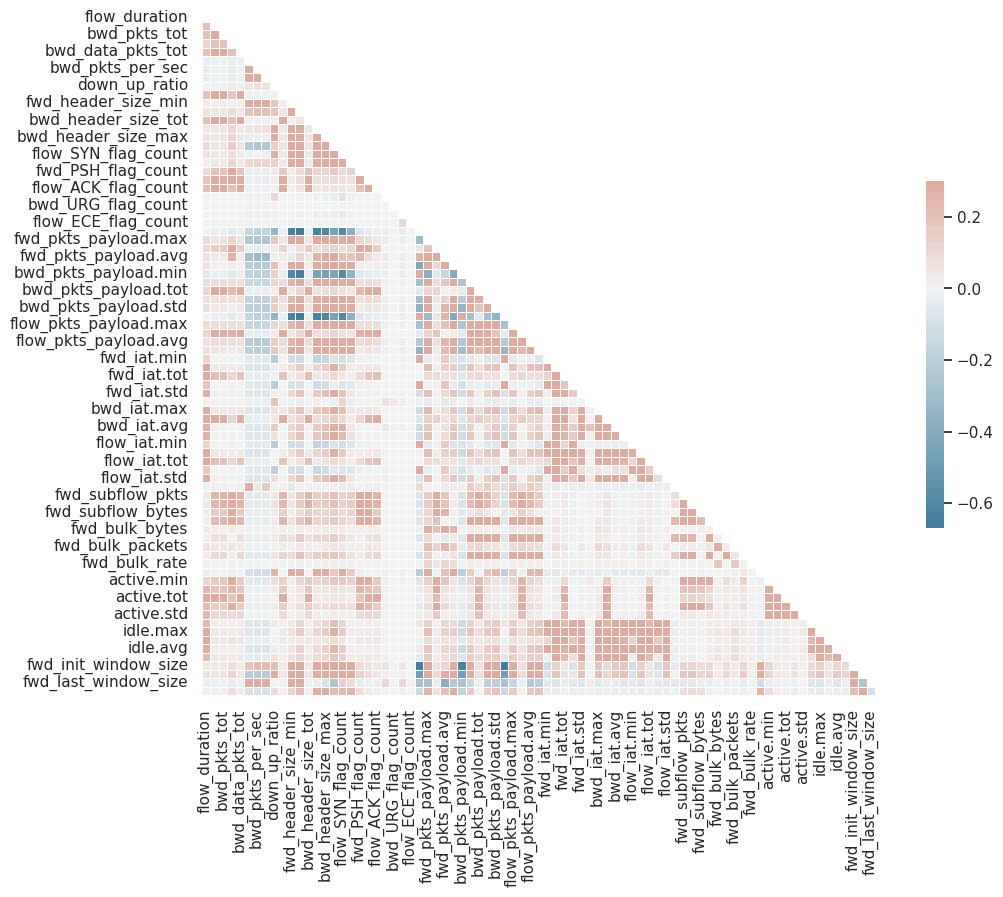

In [10]:
def show_corr_matrix():
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = ds.loc[:, ds.columns != 'traffic_category'].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
show_corr_matrix()

In [11]:
def compute_ratio(data):
    # Get ratio instead of raw numbers using normalize=True
    ratio = data['traffic_category'].value_counts(normalize=True)

    # Round and then convert to percentage
    ratio = ratio.round(4)*100

    # convert to a DataFrame and store in variable 'traffic_category_ratios'
    # We'll use this variable to compare ratios for samples 
    # selected using SRS and Stratified Sampling 
    traffic_category_ratios = pd.DataFrame({'Ratio':ratio})
    print(traffic_category_ratios)
    
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               62.57
Background           30.64
Probing               4.21
Bruteforce            1.06
Bruteforce-XML        0.93
XMRIGCC CryptoMiner   0.59


In [12]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [13]:
sampling_weights = {'Background': 6558, 'Benign': 6558, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

In [14]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_res)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=ds.loc[y_res.index].traffic_category)

This random forest with max depth 6 is better then any other max depth, and by descreasing the number of estimator to two we can see that the f1 is still 0,96 

In [16]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum(tf.cast(tf.math.greater(y_true, y_pred), tf.float32), axis=0)
    fn = tf.reduce_sum(tf.cast(tf.math.greater(y_pred, y_true), tf.float32), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

In [ ]:
def stratified_under_sample(group: pd.DataFrame, k: int, random_state: int):
    # shuffle data
    group = group.sample(frac=1, random_state=random_state)
    
    # making a dictionary for checking if all the groups are equally insert into the array
    unique_categories = set(group)
    
    # getting the size of each category per fold
    category_size = len(group) // len(unique_categories) // k
    
    # storing temporary data
    test_res = []
    train_res = []

    for i in range(k):
        test_indexes = []
        train_indexes = []
        
        # for each iteration of the outer loop we need to reset dict
        count_type = {category: 0 for category in unique_categories}
        
        # making a window of data to retreive
        start = category_size * i
        stop = category_size * (i + 1)
        for category in unique_categories:
            test_indexes.extend(group[group == category].iloc[start:stop].index)
        
        for x in group.index:
            if x not in test_indexes:
                train_indexes.append(x)
                
        # shuffling the data with the same seed in order to have the same result in both the dataset
        np.random.shuffle(test_indexes)
        test_res.append(test_indexes)
        np.random.shuffle(train_indexes)
        train_res.append(train_indexes)
        
    return test_res, train_res

In [17]:
def initialize_model(n_features):
    model = Sequential([
        Dense(6, activation='relu', input_shape=(n_features,)),
        Dense(3, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
             optimizer = keras.optimizers.Adam(learning_rate=0.001),
             metrics=[f1_score])
    return model

In [ ]:
def cross_validation(X, y, group, verbose):
    test_kfold, train_kfold = stratified_under_sample(group, 10, 12)
    
    if type(X) == pd.core.frame.DataFrame:
        X = X.to_numpy()
    if type(y) == pd.core.frame.DataFrame:
        y = y.to_numpy()
    
    cvscores = []

    for test, train in zip(test_kfold, train_kfold):
        # questo è sbagliato
        X_train = scaler.fit_transform(X[train])
        X_test = scaler.fit_transform(X[test])

        model = initialize_model(X.shape[1])
        
        model.fit(X_train, y[train], epochs=79, batch_size=79, verbose=0)

        scores = model.evaluate(X_test, y[test], verbose=0)
        if verbose:
            print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)

        if verbose:
            print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return np.mean(cvscores), np.std(cvscores)
        
%time cross_validation(ds[x_features], ds['Label'], y_res, True)

In [18]:
model = initialize_model(79)

In [19]:
%time history = model.fit(X_train, y_train, epochs=131, batch_size=79, validation_data=(X_test, y_test))

Epoch 1/131
266/266 [==============================] - 1s 2ms/step - loss: 0.6116 - f1_score: 0.8041 - val_loss: 0.5484 - val_f1_score: 0.8518
Epoch 2/131
266/266 [==============================] - 0s 1ms/step - loss: 0.5068 - f1_score: 0.8711 - val_loss: 0.4772 - val_f1_score: 0.8791
Epoch 3/131
266/266 [==============================] - 0s 1ms/step - loss: 0.4506 - f1_score: 0.8785 - val_loss: 0.4323 - val_f1_score: 0.8846
Epoch 4/131
266/266 [==============================] - 0s 1ms/step - loss: 0.4062 - f1_score: 0.8847 - val_loss: 0.3874 - val_f1_score: 0.8882
Epoch 5/131
266/266 [==============================] - 0s 1ms/step - loss: 0.3619 - f1_score: 0.8996 - val_loss: 0.3434 - val_f1_score: 0.9220
Epoch 6/131
266/266 [==============================] - 0s 1ms/step - loss: 0.3209 - f1_score: 0.9241 - val_loss: 0.3080 - val_f1_score: 0.9249
Epoch 7/131
266/266 [==============================] - 0s 1ms/step - loss: 0.2890 - f1_score: 0.9267 - val_loss: 0.2829 - val_f1_score: 0.9253

In [20]:
%time y_predicted_train = model.predict(X_train) > 0.5
%time y_predicted_test = model.predict(X_test) > 0.5

656/656 [==============================] - 0s 525us/step
CPU times: user 509 ms, sys: 49.1 ms, total: 558 ms
Wall time: 497 ms
164/164 [==============================] - 0s 463us/step
CPU times: user 134 ms, sys: 12.2 ms, total: 146 ms
Wall time: 133 ms


In [21]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.940243,0.936345
1,PRECISION,0.895327,0.889456
2,RECALL,0.997045,0.996570
3,F1 SCORE,0.943452,0.939971
4,AUC,0.940246,0.936333


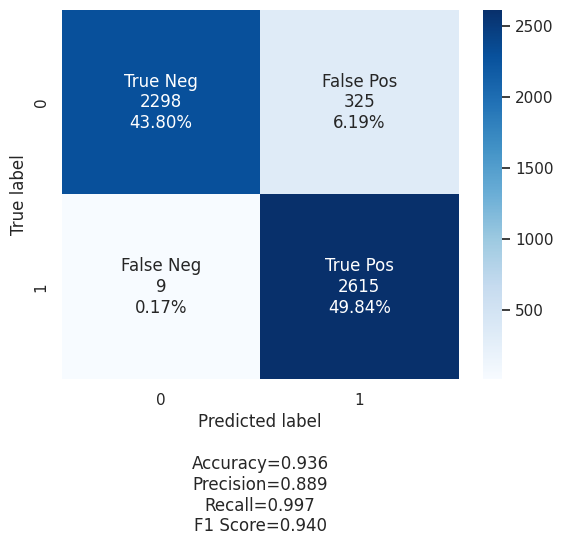

In [22]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [23]:
%%time

explainer = DeepExplainer(model, scaled_data)
sv = explainer.shap_values(scaled_data)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


CPU times: user 23min 35s, sys: 26.2 s, total: 24min 1s
Wall time: 15min 25s


In [24]:
exp = Explanation(sv,
                  explainer.expected_value.numpy(),
                  data=ds[x_features].values, 
                  feature_names=ds[x_features].columns)

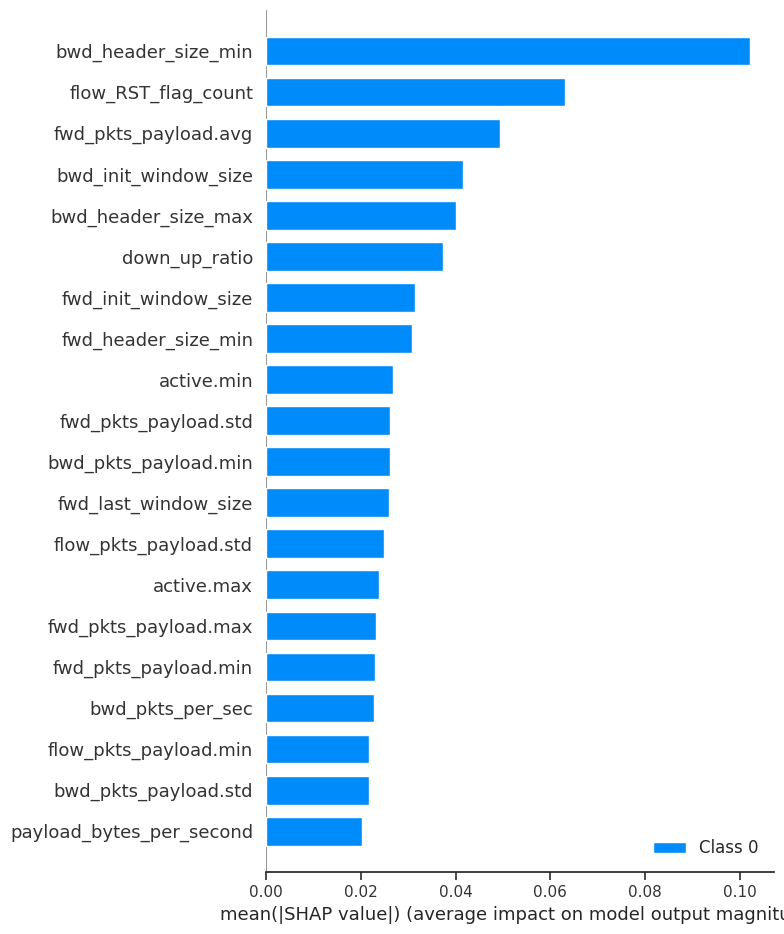

In [25]:
import shap
shap.summary_plot(exp, max_display=20)

In [31]:
feature_importance = pd.DataFrame(data={'importance' : exp[0].abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
17,0.087820,flow_RST_flag_count
13,0.086291,bwd_header_size_min
10,0.081470,fwd_header_size_min
30,0.054724,bwd_pkts_payload.min
11,0.054464,fwd_header_size_max
15,0.051296,flow_FIN_flag_count
28,0.049911,fwd_pkts_payload.avg
76,0.045084,fwd_init_window_size
29,0.032325,fwd_pkts_payload.std
16,0.029734,flow_SYN_flag_count


In [32]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [29]:
def get_score(features):
    print(f'Trying with {len(features)} features')
    cv_results_mean, cv_results_std = cross_validation(ds[features], ds['Label'],False)
    return cv_results_mean, cv_results_std, len(features)

def recursive_reduction():
    scores = []
    score_std = []
    n_features = []
    
    result = get_score(feature_above_zero)
    scores.append(result[0])
    score_std.append(result[1])
    n_features.append(result[2])    
    
    for i in range(1,len(feature_above_zero)):
        result = get_score(feature_above_zero[:-i])
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])
        
    return scores, score_std, n_features

result = recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2]})

Trying with 78 features
Trying with 77 features
Trying with 76 features
Trying with 75 features
Trying with 74 features
Trying with 73 features
Trying with 72 features
Trying with 71 features
Trying with 70 features
Trying with 69 features
Trying with 68 features
Trying with 67 features
Trying with 66 features
Trying with 65 features
Trying with 64 features
Trying with 63 features
Trying with 62 features
Trying with 61 features
Trying with 60 features
Trying with 59 features
Trying with 58 features
Trying with 57 features
Trying with 56 features
Trying with 55 features
Trying with 54 features
Trying with 53 features
Trying with 52 features
Trying with 51 features
Trying with 50 features
Trying with 49 features
Trying with 48 features
Trying with 47 features
Trying with 46 features
Trying with 45 features
Trying with 44 features
Trying with 43 features
Trying with 42 features
Trying with 41 features
Trying with 40 features
Trying with 39 features
Trying with 38 features
Trying with 37 f

In [30]:
#feature_reduction_scores = pd.read_csv('feature_reduction_score_mlp.csv', index_col=0)

In [31]:
feature_reduction_scores.to_csv('feature_reduction_score_mlp.csv')

<Axes: xlabel='n_features', ylabel='F1_score'>

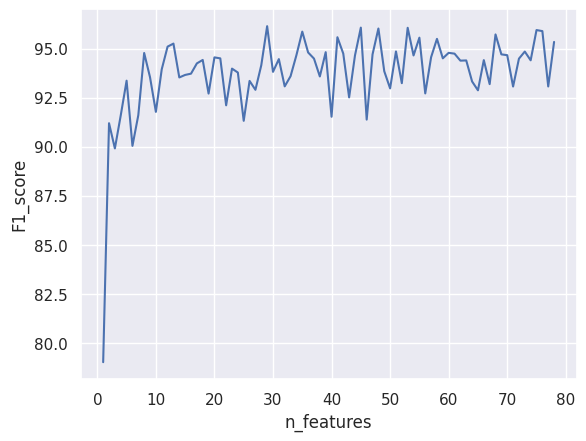

In [32]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

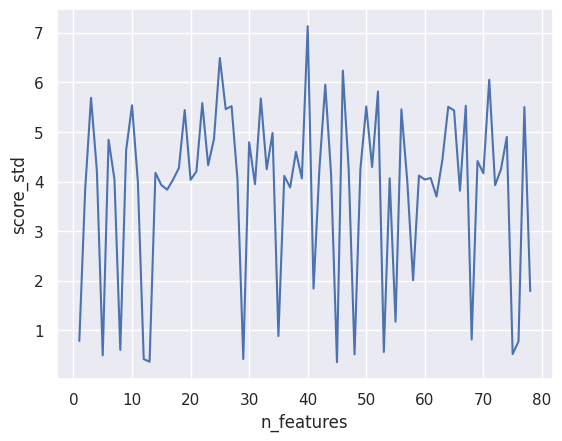

In [33]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [41]:
# add also training time

attack_f1 = []
attack_recall = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time = []

def test_zero_day(attack, features):
    # counting how many observation per class we have
    original_weights = ds.groupby('traffic_category', observed=False).count().Label.to_dict()
    # saving a value with the same length of the dataset to be overwritten by the minimun value of a feature class
    minor_class_len = ds.shape[0]
    
    sampling_weights = {'Background': 3279, 'Benign': 3279, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}

    # selecting the minimun between the value in sampling_weights dict and minor_class_len
    sampling_weights[attack] = 0
    for key in list(original_weights.keys()):
        if key != attack:
            minor_class_len = min(minor_class_len, original_weights[key])

    # making a new sampling_weights dict with the attack class removed
    for key in list(sampling_weights.keys()):
        if key != attack:
            sampling_weights[key] = minor_class_len
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    
    # making the split
    test_kfold, train_kfold = stratified_under_sample(y_res, 10, 12)
    cv_results = cross_validation(ds[features], ds['Label'], y_res, False)
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=42,  stratify=ds.loc[y_res.index].traffic_category)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    model = initialize_model(len(features))
    
    start_fit = time.time()
    model.fit(X_train,y_train, epochs=79, batch_size=79, verbose=2)
    end_fit = time.time()
    
    start_pred = time.time()
    y_predicted = model.predict(ds.where(ds.traffic_category == attack)[features].dropna()) > 0.5
    end_pred = time.time()
    
    attack_f1.append(metrics.f1_score(ds.where(ds.traffic_category == attack)['Label'].dropna().to_list(), y_predicted))
    attack_recall.append(metrics.recall_score(ds.where(ds.traffic_category == attack)['Label'].dropna().to_list(), y_predicted))
    cv_score_avg.append(cv_results)
    cv_score_std.append(cv_results)
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

def recursive_reduction(attack):
    print(attack, len(x_features))
    test_zero_day(attack, x_features)
    '''
    print(attack, len(feature_above_zero))
    test_zero_day(attack, feature_above_zero)


    for i in range(1,len(feature_above_zero)):
        print(attack, len(feature_above_zero[:-i]))
        test_zero_day(attack, feature_above_zero[:-i])
    '''
        
for attack in ['XMRIGCC CryptoMiner']: #,'Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
XMRIGCC CryptoMiner 79
Epoch 1/79
261/261 - 1s - loss: 0.4915 - f1_score: 0.8388 - 549ms/epoch - 2ms/step
Epoch 2/79
261/261 - 0s - loss: 0.3994 - f1_score: 0.9314 - 196ms/epoch - 752us/step
Epoch 3/79
261/261 - 0s - loss: 0.3510 - f1_score: 0.9385 - 206ms/epoch - 791us/step
Epoch 4/79
261/261 - 0s - loss: 0.3088 - f1_score: 0.9469 - 210ms/epoch - 805us/step
Epoch 5/79
261/261 - 0s - loss: 0.2774 - f1_score: 0.9482 - 226ms/epoch - 865us/step
Epoch 6/79
261/261 - 0s - loss: 0.2562 - f1_score: 0.9487 - 218ms/epoch - 833us/step
Epoch 7/79
261/261 - 0s - loss: 0.2411 - f1_score: 0.9490 - 243ms/epoch - 930us/step
Epoch 8/79
261/261 - 0s - loss: 0.2291 - f1_score: 0.9500 - 250ms/epoch - 959us/step
Epoch 9/79
261/261 - 0s - loss: 0.2196 - f1_score: 0.9509 - 195ms/epoch - 746us/step
Epoch 10/79
261/261 - 0s - loss: 0.2083 - f1_score: 0.9517 - 198ms/epoch - 761us/step
Epoch 11/79
261/261 - 0s - loss: 0.1960 - f1_score: 0.9551 - 203ms/epoch - 778us/step
Epoch 12/7

In [43]:
zero_day_feature_reduction_scores

,attack_f1,attack_recall,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time
0,0.0,0.0,"(95.84044218063354, 0.2926759854045654)","(95.84044218063354, 0.2926759854045654)",79,XMRIGCC CryptoMiner,19.13985,0.6754


# ricordarsi di salvare questi dati

In [36]:
zero_day_feature_reduction_scores.to_csv('zero_day_feature_reduction_scores.csv')

In [42]:
zero_day_feature_reduction_scores.query('cv_score_avg > 0.95 & attack_recall > 0').sort_values('attack_recall', ascending=False)

TypeError: '>' not supported between instances of 'tuple' and 'float'

In [38]:
zero_day_feature_reduction_scores.query('n_features == 5').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time
